In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import cv2 
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
with open("CAPTCHA/features/train", 'rb') as f:
    features = pickle.load(f)

In [3]:
with open("CAPTCHA/features/validation", 'rb') as f:
    validation = pickle.load(f)

In [4]:
targets = []
filenames = []

features += validation

for i in features:
    filenames.append(os.path.join("CAPTCHA", i[0]))
    targets.append(i[1])

In [5]:
df = pd.DataFrame()

df["label"] = np.asarray(targets)
df["file"] = np.asarray(filenames)

In [6]:
df

,label,file
0,3IODXP,CAPTCHA/images/train/3IODXP.png
1,DQQ1ND,CAPTCHA/images/train/DQQ1ND.png
2,30WOHF,CAPTCHA/images/train/30WOHF.png
3,J4ESDK,CAPTCHA/images/train/J4ESDK.png
4,6KMO3J,CAPTCHA/images/train/6KMO3J.png
...,...,...
35995,K1GV41,CAPTCHA/images/validation/K1GV41.png
35996,P595DO,CAPTCHA/images/validation/P595DO.png
35997,EIFUMB,CAPTCHA/images/validation/EIFUMB.png
35998,OCDHGT,CAPTCHA/images/validation/OCDHGT.png


In [7]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.7)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 17640, valid count: 7560, test count: 10800


In [20]:
def get_label_pos(l, label_choices):
    for i in range(len(label_choices)):
        if l == label_choices[i]:
            return i

In [19]:
from tensorflow.keras.utils import to_categorical
from PIL import Image


def get_data_generator(df, indices, for_training, batch_size=16, label_choices=[]):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            im = Image.open(file)
            im = im.convert("RGB")
            #im = im.resize((H, W)) # Probably need to comment
            im = np.array(im) / 255.0
            images.append(np.array(im))
            #print(np.array(to_categorical(ord(i), N_LABELS)) for i in label)
            labels.append(np.array([np.array(to_categorical(get_label_pos(i, label_choices), N_LABELS)) for i in label]))
            if len(images) >= batch_size:
#                 print(np.array(images), np.array(labels))
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

In [18]:
H, W, C = 90, 300, 3
#H, W, C = 100, 120, 3
label_choices = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
N_LABELS = len(label_choices)
#N_LABELS=256
D = 6

In [24]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

input_layer = tf.keras.Input(shape=(H, W, C))
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

x = layers.Dense(D * N_LABELS, activation='softmax')(x)
x = layers.Reshape((D, N_LABELS))(x)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 90, 300, 3)]      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 88, 298, 32)       896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 44, 149, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 42, 147, 64)       18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 21, 73, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 35, 64)         0   

In [11]:
#train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
#for i in train_gen:
#    print(i)
#break

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size, label_choices=label_choices)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size, label_choices=label_choices)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=1,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

275/275 [==============================] - 347s 1s/step - loss: 3.5958 - accuracy: 0.0265 - val_loss: 3.5836 - val_accuracy: 0.0278


In [27]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128, label_choices=label_choices)
x_test, y_test = next(test_gen)

y_pred = model.predict_on_batch(x_test)

y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)

In [30]:
def format_y(y, label_choices):
    return ''.join(map(lambda x: label_choices[int(x)], y))

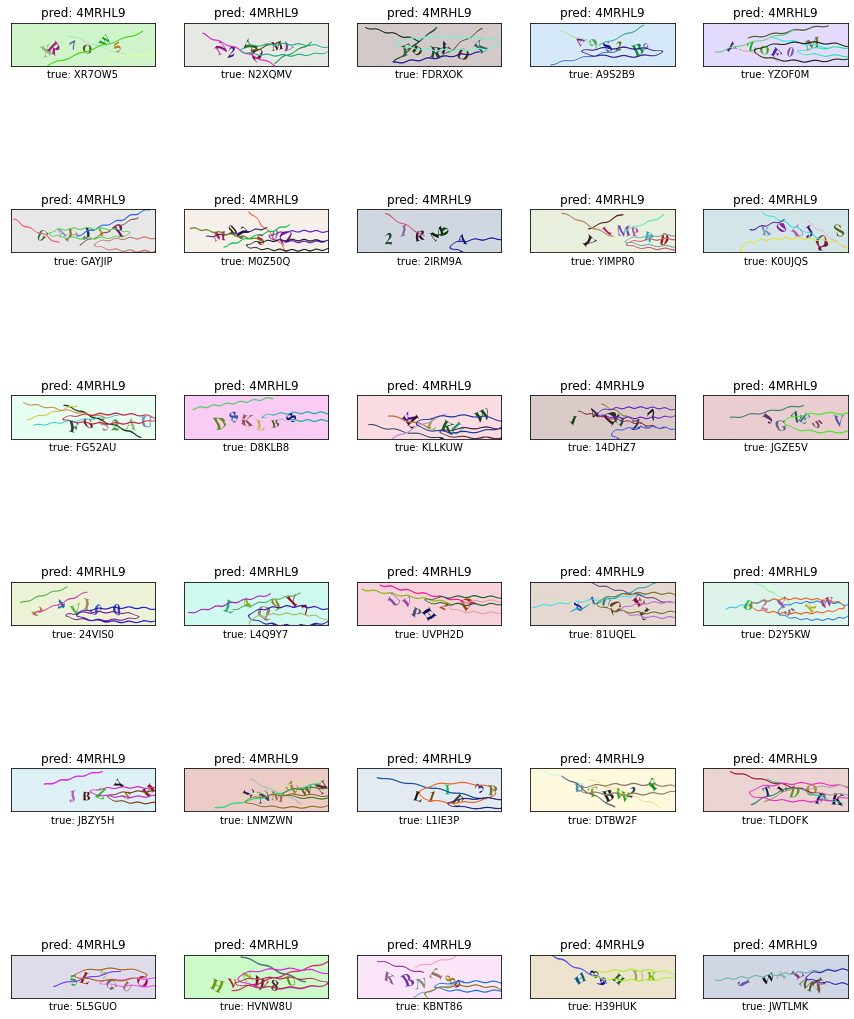

In [31]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('pred: %s' % format_y(y_pred[img_idx], label_choices))
    ax.set_xlabel('true: %s' % format_y(y_true[img_idx], label_choices))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()